In [201]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 101)

In [9]:
raw = pd.read_csv('../data/interim/merged_19.csv')

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
for col in raw.columns:
    print(col)

Unnamed: 0
RCDTS
Type
School Name
District
City
County
District Type
District Size
School Type
Grades Served
Summative Designation
State Senate District
State Representative District
# Student Enrollment
% Student Enrollment - White
% Student Enrollment - Black or African American
% Student Enrollment - Hispanic or Latino
% Student Enrollment - Asian
% Student Enrollment - Native Hawaiian or Other Pacific Islander
% Student Enrollment - American Indian or Alaska Native
% Student Enrollment - Two or More Races
% Student Enrollment - EL
% Student Enrollment - IEP
% Student Enrollment - Low Income
% Student Enrollment - Homeless
Total Number of School Days
Student Attendance Rate
Student Attendance Rate - Male
Student Attendance Rate - Female
Student Attendance Rate - White
Student Attendance Rate - Black or African American
Student Attendance Rate - Hispanic or Latino
Student Attendance Rate - Asian
Student Attendance Rate - Native Hawaiian or Other Pacific Islander
Student Attendance Ra

In [12]:
raw.Type.value_counts()

School       3888
District      865
Statewide       1
Name: Type, dtype: int64

# Districts

## Nulls

In [13]:
districts = raw[raw.Type == 'District']

In [21]:
all_nulls = districts.apply(lambda row: row.isnull().all())
no_null_columns = districts.drop(columns=all_nulls[all_nulls].index)

In [22]:
no_null_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 4732
Columns: 553 entries, Unnamed: 0 to Year
dtypes: float64(544), int64(2), object(7)
memory usage: 3.7+ MB


In [33]:
no_null_columns.apply(lambda row: row.isnull().any()).sum()
# 547 / 553 columns have at least one null value

547

In [28]:
no_null_columns.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 4732
Data columns (total 553 columns):
Unnamed: 0                                                                                         865 non-null int64
RCDTS                                                                                              865 non-null object
Type                                                                                               865 non-null object
District                                                                                           865 non-null object
City                                                                                               859 non-null object
County                                                                                             859 non-null object
District Type                                                                                      858 non-null object
District Size                                                

- lots of nulls in race (perhaps they omit if it's zero - could check if they add up to 1)
    - same for attendence rate by race (altho numbers don't exactly line up)
    - and mobility rate
- high school drop out rate is surprisinly only half full (417) - (min is 0.1 so plausible assumption)
    - same by race questions
- high school graduation rate only has 479 results (unclear why) - so only 480 districts across HS in database
    - 477 5 year, 475 for 6th year
    - same issues with race
- avg class size for high school is also only like 476 (perhaps districts don't have high schools?????)
- avg min per day math/sci/engl for grades 3,6,8 at ~760 (perhaps only those have those grades? matches avg class size metrics)
    - DISTRICTS DON'T HAVE ANY "GRADES SERVED" DATA - hmmm
- same potential issue with race of teachers
- potentially same issue with avg teaching exp with high/low poverty
- only 483 pupil/teacher ratio HS (has zeros, how would that be zero - no high school students?)
- also only 766 pupil/teach ratio elementary
- Community College remediation (471)




-------- Columns with Few Nulls ------------
avg teaching exp (862)
phys edu (860)
truancy(860)
mobility rate/attendence rate/school days (860)
enrollment/district info (865)
Bach/Master degree
pupil ratio, teacher sal, admin sal, retention rate, princ turnover, teacher attendence/eval
chronic absenteeism


----- very low -----
AP/IB classes



In [35]:
no_null_columns['Pupil Teacher Ratio - High School'].describe()

count    483.000000
mean      15.560870
std        4.797192
min        0.000000
25%       12.400000
50%       16.200000
75%       18.900000
max       33.900000
Name: Pupil Teacher Ratio - High School, dtype: float64

### How Many High Schools Are There?

In [54]:
high_schools = raw[
    (raw.Type == 'School') &
    ~raw['Grades Served'].str.contains('12', na=False) &
    (raw['Grades Served'].str.contains('11') |
    raw['Grades Served'].str.contains('10') |
    raw['Grades Served'].str.contains('9'))
]

In [56]:
high_schools['Grades Served'].head()
# 5 high schools have at least one grade but don't go up to 12

131      6 7 8 9
194            9
516            9
699            9
1506        9 10
Name: Grades Served, dtype: object

In [61]:
raw[raw.District.isin(high_schools['District']) & (raw.District != 'City of Chicago SD 299')][['District', 'Grades Served']]
# but they have a different high school that does go up to 12

,District,Grades Served
129,Effingham CUSD 40,NaN
130,Effingham CUSD 40,9 10 11 12
131,Effingham CUSD 40,6 7 8 9
132,Effingham CUSD 40,PK 2 3 4 5 6
133,Effingham CUSD 40,PK K
134,Effingham CUSD 40,1 2
192,Harlem UD 122,NaN
193,Harlem UD 122,9 10 11 12
194,Harlem UD 122,9
195,Harlem UD 122,7 8


In [66]:
districts_with_high_schools = raw[(raw.Type == 'School') & raw['Grades Served'].str.contains('12', na=False)].District.unique()
len(districts_with_high_schools)
# Seems like this is a good estimate for the number of districts with high schools

480

In [62]:
high_schools = raw[
    (raw.Type == 'School') &
    raw['Grades Served'].str.contains('13', na=False)
]

### What is up with 483 have pupil/teacher for HS but only 480 HS?

In [67]:
raw[~raw['Pupil Teacher Ratio - High School'].isnull() & ~raw.District.isin(districts_with_high_schools)]

,Unnamed: 0,RCDTS,Type,School Name,District,City,County,District Type,District Size,School Type,...,Black or African American Students SAT ELA Participation %,Hispanic or Latino Students SAT ELA Participation %,Asian Students SAT ELA Participation %,Native Hawaiian or Other Pacific Islander Students SAT ELA Participation %,American Indian or Alaska Native Students SAT ELA Participation %,Two or More Race Students SAT ELA Participation %,IEP Students SAT ELA Participation %,EL Students SAT ELA Participation %,Low Income Students SAT ELA Participation %,Year
921,921,70161550020000,District,NaN,Calumet City SD 155,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
925,925,70161560020000,District,NaN,Lincoln ESD 156,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2133,2133,190220130020000,District,NaN,Bloomingdale SD 13,Bloomingdale,Dupage,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2202,2202,190220580020000,District,NaN,Downers Grove GSD 58,Downers Grove,Dupage,ELEMENTARY,LARGE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4327,4327,540920010260000,District,NaN,Bismarck Henning CUSD,Bismarck,Vermilion,UNIT,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4338,4338,540920070260000,District,NaN,Rossville-Alvin CUSD 7,Rossville,Vermilion,UNIT,SMALL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4753,4753,NaN,Statewide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.4,97.4,99.5,98.1,97.5,97.6,95.7,96.3,96.6,2018


In [78]:
raw[~raw['Pupil Teacher Ratio - High School'].isnull() & (raw['District Type'] == 'ELEMENTARY')]

,Unnamed: 0,RCDTS,Type,School Name,District,City,County,District Type,District Size,School Type,...,Black or African American Students SAT ELA Participation %,Hispanic or Latino Students SAT ELA Participation %,Asian Students SAT ELA Participation %,Native Hawaiian or Other Pacific Islander Students SAT ELA Participation %,American Indian or Alaska Native Students SAT ELA Participation %,Two or More Race Students SAT ELA Participation %,IEP Students SAT ELA Participation %,EL Students SAT ELA Participation %,Low Income Students SAT ELA Participation %,Year
921,921,70161550020000,District,NaN,Calumet City SD 155,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
925,925,70161560020000,District,NaN,Lincoln ESD 156,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2133,2133,190220130020000,District,NaN,Bloomingdale SD 13,Bloomingdale,Dupage,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2202,2202,190220580020000,District,NaN,Downers Grove GSD 58,Downers Grove,Dupage,ELEMENTARY,LARGE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [70]:
raw[raw.Type == 'District']['District Type'].value_counts()

UNIT           388
ELEMENTARY     371
HIGH SCHOOL     99
Name: District Type, dtype: int64

In [72]:
raw[(raw.Type == 'School') & (raw['District Type'] == 'UNIT')]['Grades Served'].value_counts()

 9 10 11 12             472
PK K 1 2 3 4 5 6 7 8    387
 K 1 2 3 4 5            311
 6 7 8                  233
PK K 1 2 3 4 5          159
                       ... 
 4 5 6 7 8 9              1
PK 5 6                    1
8                         1
5                         1
PK 2 3 4 5 6              1
Name: Grades Served, Length: 79, dtype: int64

In [77]:
raw[(raw.Type == 'School') & (raw['District Type'] == 'UNIT')]['Grades Served'].value_counts()

 9 10 11 12                        472
PK K 1 2 3 4 5 6 7 8               387
 K 1 2 3 4 5                       311
 6 7 8                             233
PK K 1 2 3 4 5                     159
 K 1 2 3 4 5 6 7 8                 103
PK K 1 2 3 4 5 6                    75
 K 1 2 3 4 5 6                      71
 7 8                                67
 5 6 7 8                            59
PK                                  58
PK K 1 2 3 4                        51
 7 8 9 10 11 12                     47
PK K 1 2                            44
 K 1 2 3 4                          44
 3 4 5                              34
 6 7 8 9 10 11 12                   25
PK K 1                              21
PK K 1 2 3                          21
 K 1 2 3                            15
 4 5 6                              15
 4 5                                15
 K 1 2                              11
 1 2 3 4 5                          11
 2 3                                11
PK K                     

In [79]:
just_high_schools = raw[(raw.Type == 'School') & raw['Grades Served'].str.contains('12', na=False)]

In [80]:
just_high_schools[just_high_schools['District Type'] == 'ELEMENTARY']

,Unnamed: 0,RCDTS,Type,School Name,District,City,County,District Type,District Size,School Type,...,Black or African American Students SAT ELA Participation %,Hispanic or Latino Students SAT ELA Participation %,Asian Students SAT ELA Participation %,Native Hawaiian or Other Pacific Islander Students SAT ELA Participation %,American Indian or Alaska Native Students SAT ELA Participation %,Two or More Race Students SAT ELA Participation %,IEP Students SAT ELA Participation %,EL Students SAT ELA Participation %,Low Income Students SAT ELA Participation %,Year


In [ ]:
# There are 4 elementary school districts that have a measure for HS Pupil Ratio
# No school in an "Elementary" school district serves any grade 9-12
# so really missing one piece of data (483 - 4 errors => one of the 480 districts with high schools)

# Conclusion: can limit to the 480 districts with High Schools

### How do the nulls look within Districts That Have High Schools?

In [98]:
high_districts = no_null_columns[no_null_columns.District.isin(just_high_schools.District.unique())]

In [103]:
high_districts.columns = [x.replace(' ', '_').replace('-', '').lower() for x in high_districts.columns]

In [104]:
high_districts.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 4732
Data columns (total 553 columns):
unnamed:_0                                                                                         480 non-null int64
rcdts                                                                                              480 non-null object
type                                                                                               480 non-null object
district                                                                                           480 non-null object
city                                                                                               475 non-null object
county                                                                                             475 non-null object
district_type                                                                                      475 non-null object
district_size                                                

In [ ]:
sat_reading_total_students_level_1_%                                                               474 non-null float64
sat_reading_total_students_level_2_%                                                               474 non-null float64
sat_reading_total_students_level_3_%                                                               474 non-null float64
sat_reading_total_students_level_4_%                                                               474 non-null float64
sat_math_total_students_level_1_%                                                                  474 non-null float64
sat_math_total_students_level_2_%                                                                  474 non-null float64
sat_math_total_students_level_3_%                                                                  474 non-null float64
sat_math_total_students_level_4_%
# don't replace nulls of these -> but do for every thing else 'sat_reading_total' or 'sat_math_total'

- student enrollment (sum to 1)
- student attendence (sum to 1)
- student mobility (sum to 1)
- student high school dropout rate (sum to 1)
- high school grad rate (4/5/6)
- teacher race


### Do sum of % student enrollments equal 100?

In [107]:
high_districts['%_student_enrollment__white'] +\
high_districts['%_student_enrollment__black_or_african_american'] +\
high_districts['%_student_enrollment__hispanic_or_latino'] +\
high_districts['%_student_enrollment__asian'] +\
high_districts['%_student_enrollment__native_hawaiian_or_other_pacific_islander'] +\
high_districts['%_student_enrollment__american_indian_or_alaska_native'] +\
high_districts['%_student_enrollment__two_or_more_races']

0        NaN
3        NaN
6        NaN
11       NaN
15       NaN
        ... 
4708     NaN
4717     NaN
4723     NaN
4728     NaN
4732    99.9
Length: 480, dtype: float64

In [115]:
just_race = high_districts[[x for x in high_districts.columns if '%_student_enrollment' in x][:-4]]

In [121]:
just_race.fillna(value=0).agg('sum', axis=1).describe([0, 0.005, 0.01, 0.02, 0.25])

count    480.000000
mean      98.870000
std        1.317434
min       91.200000
0%        91.200000
0.5%      93.316000
1%        94.537000
2%        95.258000
25%       98.400000
50%       99.300000
max      100.100000
dtype: float64

In [122]:
# Assume blanks are zeros in most cases

### Assume SAT will be explanatory variable

In [130]:
no_sat_data = high_districts[high_districts['sat_math_total_students_level_1_%'].isnull() &
                             high_districts['sat_reading_total_students_level_1_%'].isnull() &
                             high_districts['sat_reading_total_students_level_4_%'].isnull() &
                             high_districts['sat_math_total_students_level_4_%'].isnull()
                            ]


In [133]:
with_sat = high_districts.dropna(subset=['sat_math_total_students_level_1_%'])
# there are 6 with no values and they all don't have values for that single column

In [135]:
with_sat.shape

(474, 553)

### Assume missing values are zero

In [139]:
column_includes_na_zero = [
    'sat_math_participation',
    'sat_ela_participation',
    '%_student_enrollment',
    'student_attendance_rate_', # remake null for 4 where the total student_attendance_rate is na
    'student_mobility_rate_',
    'high_school_dropout_rate', # assuming null means no student dropped out for that district (63/480)
    'high_school_4year_graduation_rate_', # remake null for 2 where the total rate is na
    '%_of_teachers_', # remake null for dist with null white/fte/exp/bach/masters (3/480)
    'chronic_absenteeism_', # remake null for for 4 where chronic_absenteeism is na
    'sat_reading_total',
    'sat_math_total'
]

In [140]:
col_fill_zero = [x for x in with_sat.columns if any([y in x for y in column_includes_na_zero])]

In [141]:
col_fill_zero

['%_student_enrollment__white',
 '%_student_enrollment__black_or_african_american',
 '%_student_enrollment__hispanic_or_latino',
 '%_student_enrollment__asian',
 '%_student_enrollment__native_hawaiian_or_other_pacific_islander',
 '%_student_enrollment__american_indian_or_alaska_native',
 '%_student_enrollment__two_or_more_races',
 '%_student_enrollment__el',
 '%_student_enrollment__iep',
 '%_student_enrollment__low_income',
 '%_student_enrollment__homeless',
 'student_attendance_rate__male',
 'student_attendance_rate__female',
 'student_attendance_rate__white',
 'student_attendance_rate__black_or_african_american',
 'student_attendance_rate__hispanic_or_latino',
 'student_attendance_rate__asian',
 'student_attendance_rate__native_hawaiian_or_other_pacific_islander',
 'student_attendance_rate__american_indian_or_alaska_native',
 'student_attendance_rate__two_or_more_races',
 'student_attendance_rate__el',
 'student_mobility_rate__male',
 'student_mobility_rate__female',
 'student_mobili

In [143]:
col_fill_zero.remove('high_school_4year_graduation_rate__total')

In [147]:
with_sat[col_fill_zero] = with_sat[col_fill_zero].fillna(value=0)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Remove any column with less than 400 data points

In [153]:
few_nulls = with_sat.dropna(thresh=len(with_sat) - 80, axis=1)

In [156]:
few_nulls.shape
# removed ~40% of the columns

(474, 337)

# Duplicates

In [161]:
few_nulls.groupby('district').agg('count').rcdts.value_counts()

1    474
Name: rcdts, dtype: int64

# Distributions

In [162]:
few_nulls.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 4732
Data columns (total 337 columns):
unnamed:_0                                                                        int64
rcdts                                                                             object
type                                                                              object
district                                                                          object
city                                                                              object
county                                                                            object
district_type                                                                     object
district_size                                                                     object
#_student_enrollment                                                              float64
%_student_enrollment__white                                                       float64
%_

## Student Demos

In [169]:
student_demo_cols = [
    '#_student_enrollment',
    '%_student_enrollment__white',
    '%_student_enrollment__black_or_african_american',
    '%_student_enrollment__homeless',
    '%_student_enrollment__low_income',
    '%_student_enrollment__iep',
    '%_student_enrollment__el',
    'student_attendance_rate',
    'student_mobility_rate',
    'student_chronic_truancy_rate',
]

In [188]:
# student demos
few_nulls[student_demo_cols].describe([.1, .25, .5, .75, .9])
# order of mag increase from 99.5% to 99.9% in student enrollment
# prob no district has 0% white students -> handled nulls incorrectly
# % low_income jumps from 90% to 99% (mid 60's to mid 90's)
# pretty long tail for truancy as well
# attendance and mobility also pretty normal

,#_student_enrollment,%_student_enrollment__white,%_student_enrollment__black_or_african_american,%_student_enrollment__homeless,%_student_enrollment__low_income,%_student_enrollment__iep,%_student_enrollment__el,student_attendance_rate,student_mobility_rate,student_chronic_truancy_rate
count,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000
mean,2308.414376,79.079281,6.146512,1.854123,42.715645,15.317336,2.496617,94.073150,8.149260,5.994503
std,3911.820581,23.975842,15.613781,2.970139,18.457999,3.368913,5.642509,1.936223,3.886445,8.286379
min,124.000000,0.000000,0.000000,0.000000,2.100000,0.000000,0.000000,78.700000,1.000000,0.000000
10%,355.200000,42.540000,0.000000,0.000000,18.000000,11.500000,0.000000,92.300000,3.900000,0.800000
25%,529.000000,72.000000,0.000000,0.000000,30.000000,12.800000,0.000000,93.600000,5.500000,1.600000
50%,992.000000,90.600000,0.800000,0.800000,42.600000,15.000000,0.000000,94.500000,7.800000,3.500000
75%,2221.000000,94.800000,3.700000,2.400000,54.100000,17.500000,2.300000,95.100000,10.200000,7.400000
90%,5585.800000,96.400000,15.000000,5.300000,64.380000,20.000000,7.680000,95.700000,12.480000,13.080000
max,38764.000000,100.000000,100.000000,31.400000,99.600000,25.900000,39.000000,98.200000,35.700000,85.800000


In [191]:
few_nulls['%_student_enrollment__homeless'].sort_values(ascending=False)


2761    31.4
2833    15.7
1930    15.5
3531    14.2
2456    13.4
        ... 
1938     0.0
1933     0.0
3781     0.0
1928     0.0
0        0.0
Name: %_student_enrollment__homeless, Length: 473, dtype: float64

In [178]:
few_nulls = few_nulls[few_nulls['#_student_enrollment'] < 372214]

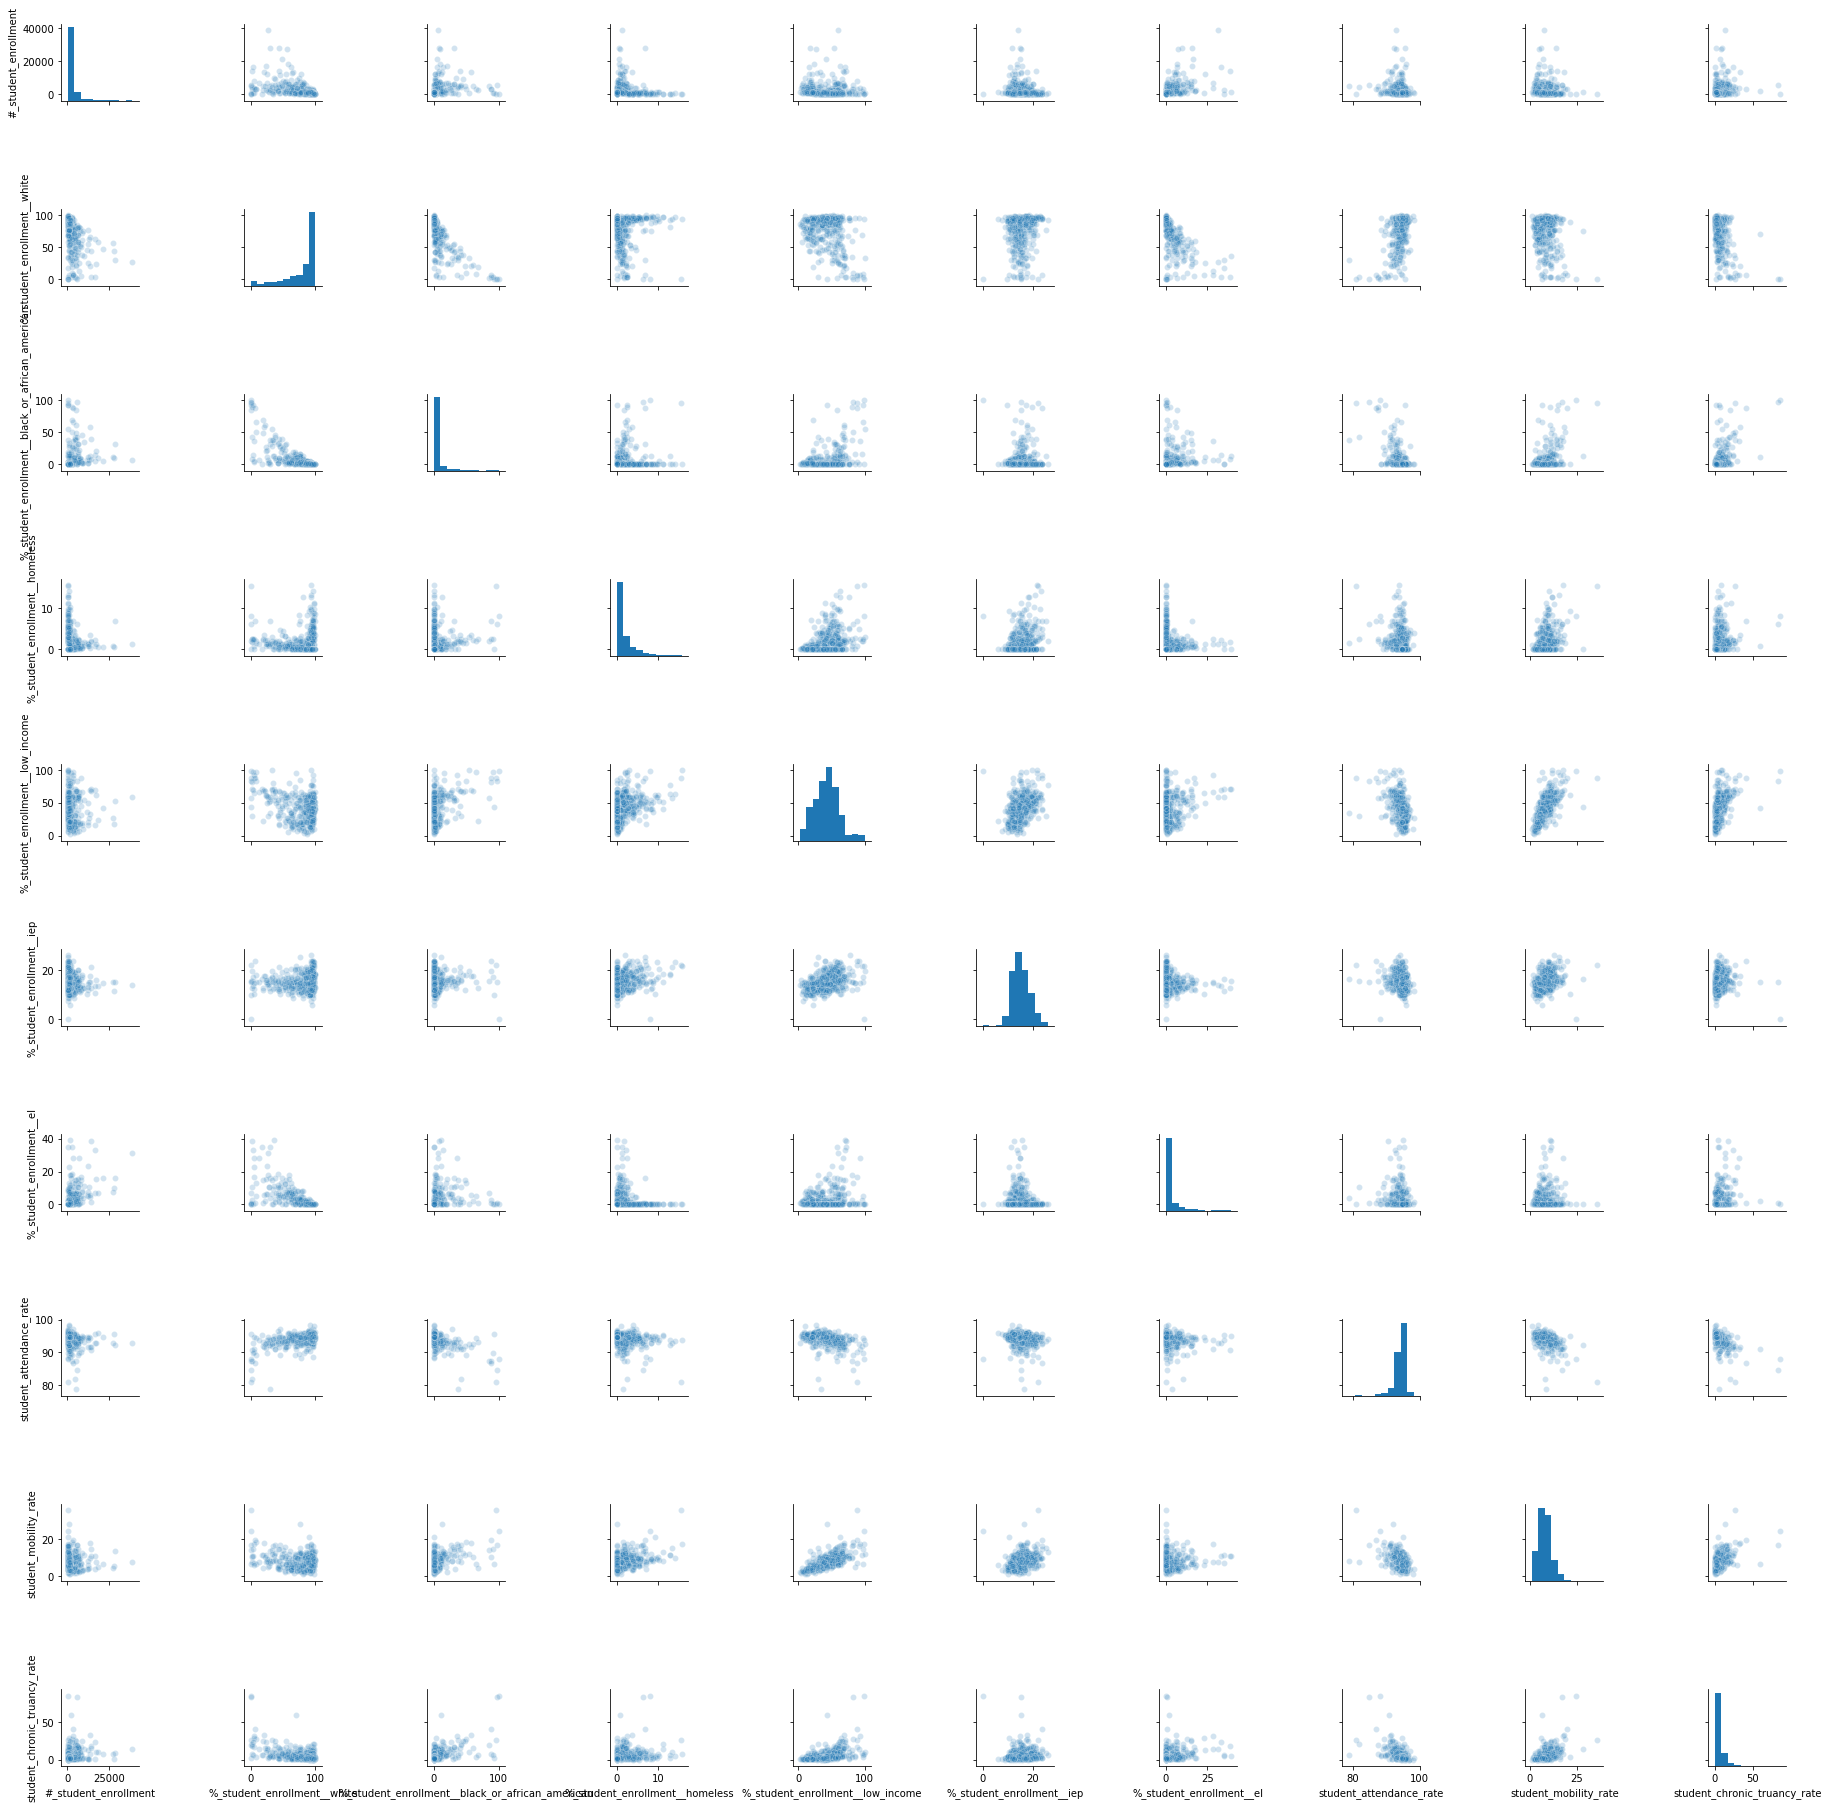

In [194]:
sns.pairplot(few_nulls[student_demo_cols], plot_kws={'alpha': 0.2})
# low income and iep are fairly normal
# black and white seems neg correl (duh)
# one district with low enrollment and a high homeless population (that district is also v black)
# attendance and mobility are normal-ish; low income and iep even more so



In [192]:
few_nulls[few_nulls['%_student_enrollment__homeless'] > 20][student_demo_cols  + ['district']]
few_nulls = few_nulls[few_nulls['%_student_enrollment__homeless'] < 20]
# district has more than double the homelessness rate of next 

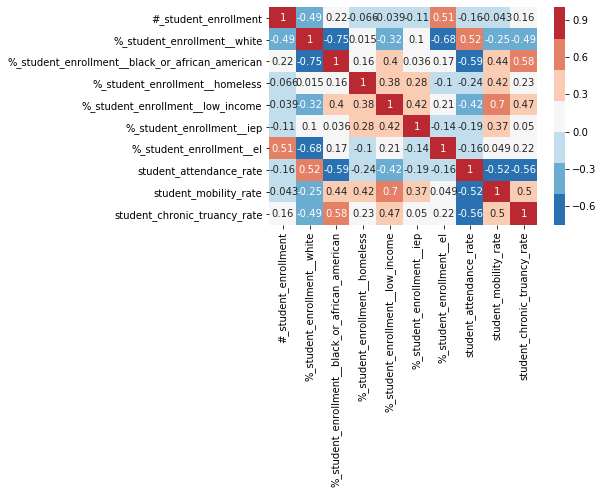

In [193]:
sns.heatmap(few_nulls[student_demo_cols].corr(), annot=True, cmap=sns.color_palette("RdBu_r", 7))
# mobility correl with lots of stuff (black, homeless, low-income, iep, truancy)
# black and white are highly neg correl (duh)
# attendance, mobility, truancy => lots of correlations
# nothing is SUPER bad

In [219]:
def eda_col_subset(df, list_of_columns):
    print(df[list_of_columns].describe([.1, .25, .5, .75, .9]))
    
    plt.figure(figsize=(40, 40))
    fig, axs = plt.subplots()
    sns.pairplot(df[list_of_columns], plot_kws={'alpha': 0.2})
    sns.heatmap(df[list_of_columns].corr(), annot=True, cmap=sns.color_palette("RdBu_r", 7), ax=axs)

## Teacher Stats

       %_of_teachers__white  %_of_teachers__black_or_african_american  \
count            472.000000                                472.000000   
mean              93.350636                                  1.384746   
std               12.469732                                  5.760265   
min                0.000000                                  0.000000   
10%               86.000000                                  0.000000   
25%               92.500000                                  0.000000   
50%               96.800000                                  0.000000   
75%               99.425000                                  0.500000   
90%              100.000000                                  2.300000   
max              100.000000                                 70.000000   

       avg_teaching_exp  bachelor_degree  masters_degree  \
count        471.000000       471.000000      471.000000   
mean          13.887049        50.449894       49.004034   
std            2

<Figure size 2880x2880 with 0 Axes>

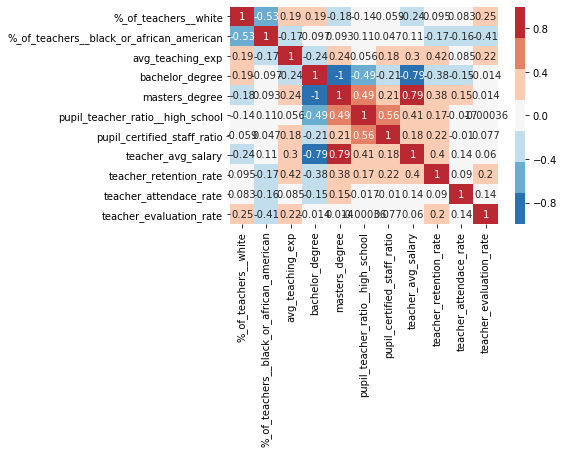

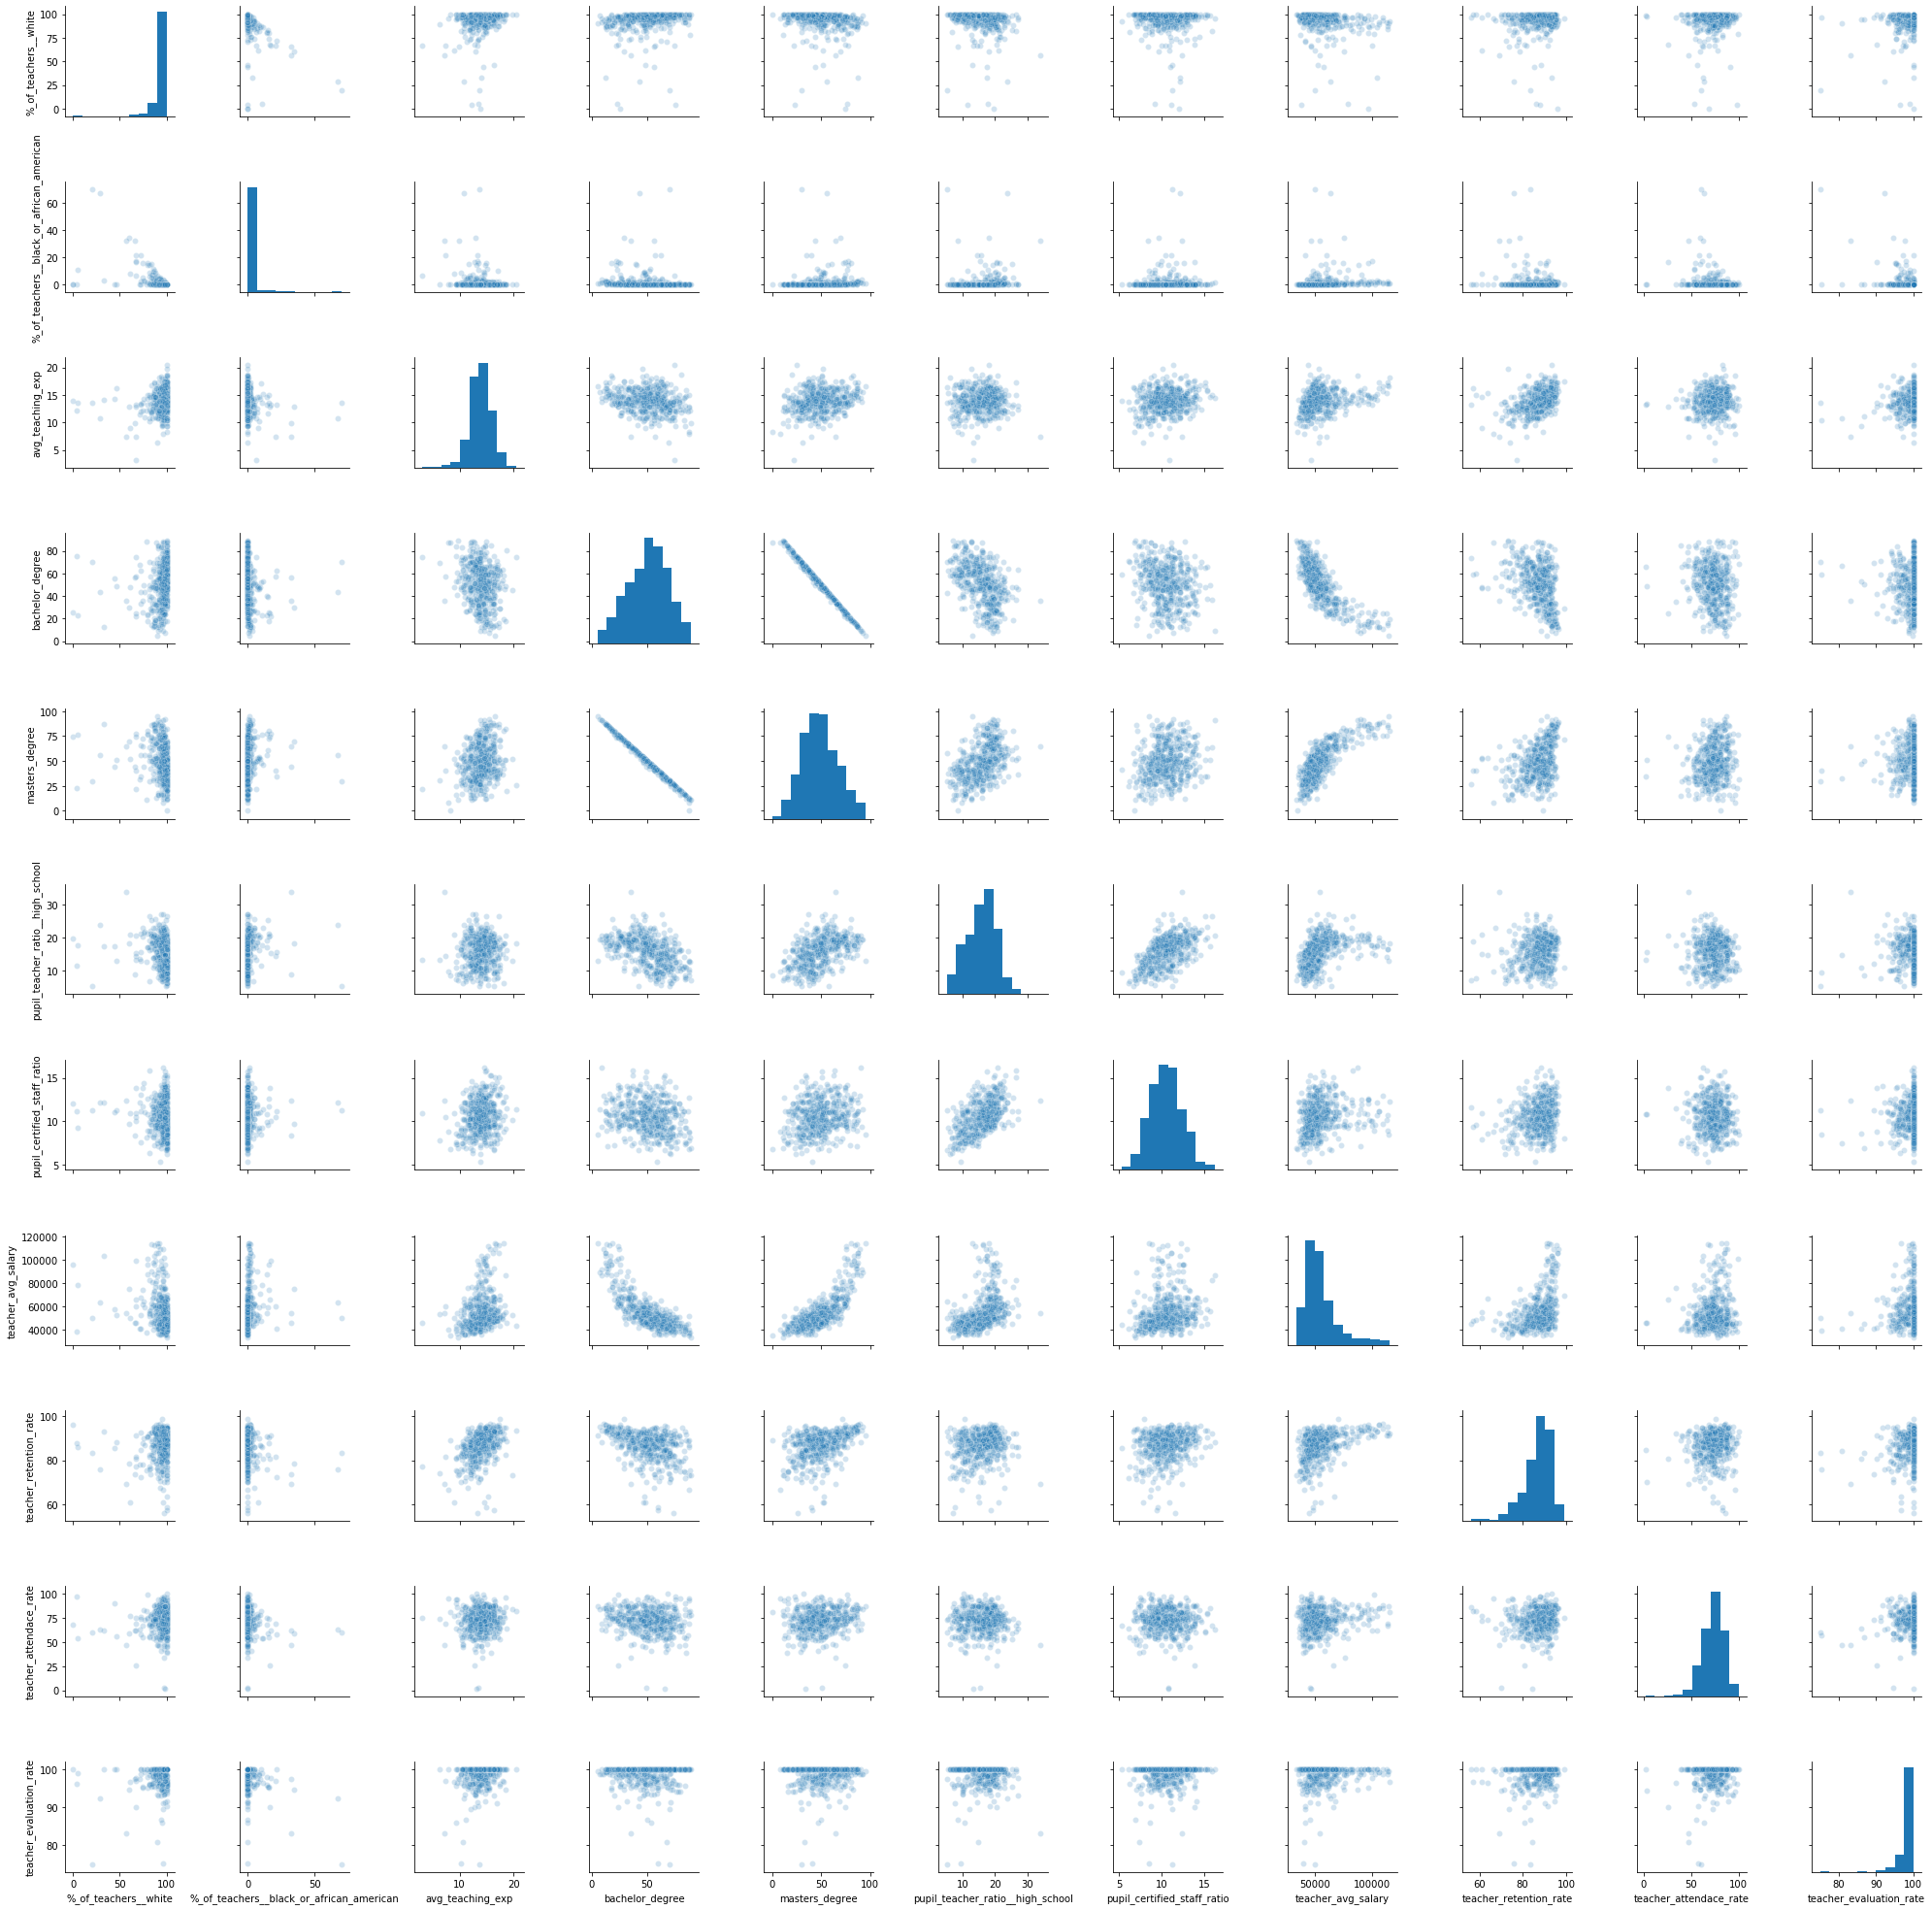

In [220]:
eda_col_subset(few_nulls, [
    '%_of_teachers__white',
    '%_of_teachers__black_or_african_american',
    'avg_teaching_exp',
    'bachelor_degree',
    'masters_degree',
    'pupil_teacher_ratio__high_school',
    'pupil_certified_staff_ratio',
    'teacher_avg_salary',
    'teacher_retention_rate',
    'teacher_attendace_rate',
    'teacher_evaluation_rate',
])
# teacher attendence rate of 1.8% has got to be an outlier/just plain wrong
# teacher salary super correlated with bachelor and master (not merit based)
# bachelor and masters are basically the same